Import

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

Load and Process Data

In [3]:
file_path = "/content/sample_data/mental_health.csv"
data = pd.read_csv(file_path)
data = data.drop(columns=['Employee_ID'], errors='ignore')
label_encoder = LabelEncoder()
data['Productivity_Change'] = label_encoder.fit_transform(data['Productivity_Change'])
categorical_cols = ['Gender', 'Job_Role', 'Industry', 'Work_Location',
                    'Stress_Level', 'Mental_Health_Condition',
                    'Access_to_Mental_Health_Resources',
                    'Satisfaction_with_Remote_Work', 'Physical_Activity',
                    'Sleep_Quality', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
data.fillna(data.mean(numeric_only=True), inplace=True)

Split and Scale Data

In [4]:
X = data.drop(columns=['Productivity_Change'])
y = data['Productivity_Change']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Dimensionality Reduction

In [9]:
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features_mask = selector.get_support()

selected_features = X.columns[selected_features_mask]

print("Selected Features by SelectKBest:")
print(selected_features.tolist())

Selected Features by SelectKBest:
['Work_Life_Balance_Rating', 'Social_Isolation_Rating', 'Job_Role_Project Manager', 'Work_Location_Onsite', 'Stress_Level_Medium', 'Mental_Health_Condition_Depression', 'Access_to_Mental_Health_Resources_Yes', 'Sleep_Quality_Good', 'Sleep_Quality_Poor', 'Region_Asia']


Train the Model

Classification Report (Initial SVM):
              precision    recall  f1-score   support

           0       0.34      0.41      0.37       338
           1       0.37      0.37      0.37       294
           2       0.34      0.28      0.30       368

    accuracy                           0.35      1000
   macro avg       0.35      0.35      0.35      1000
weighted avg       0.35      0.35      0.35      1000



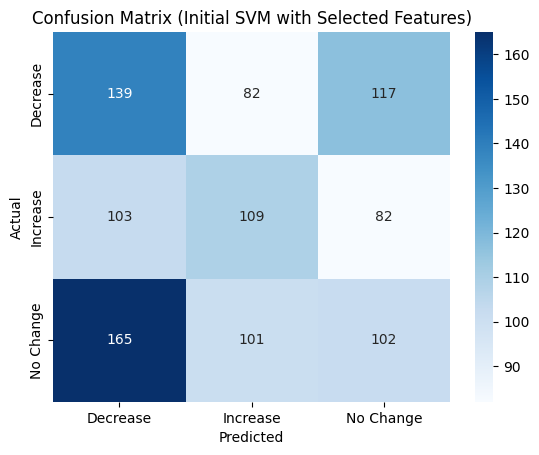

In [6]:
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_selected, y_train)
y_pred = svm.predict(X_test_selected)
print("Classification Report (Initial SVM):")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Initial SVM with Selected Features)')
plt.show()

Param Tuning

In [7]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly']
}
grid = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train_selected, y_train)
print("Best Parameters:", grid.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   3.4s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   4.5s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   3.4s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   3.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   4.2s
[CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time=   2.8s
[CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time=   2.2s
[CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time=   2.3s
[CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time=   2.3s
[CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time=   3.2s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   3.5s
[CV] END .....................C=0.01, gamma=0.0

Evaluate Model

Tuned Model Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.38      0.36       338
           1       0.36      0.43      0.39       294
           2       0.37      0.29      0.32       368

    accuracy                           0.36      1000
   macro avg       0.36      0.36      0.36      1000
weighted avg       0.36      0.36      0.36      1000



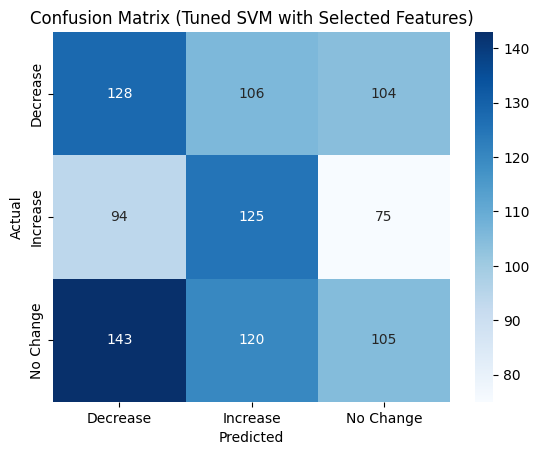

Best Parameters Found:
C: 1
Gamma: 0.1
Kernel: poly


In [10]:
best_svm = grid.best_estimator_
y_pred_best = best_svm.predict(X_test_selected)
print("Tuned Model Classification Report:")
print(classification_report(y_test, y_pred_best))
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Tuned SVM with Selected Features)')
plt.show()

print("Best Parameters Found:")
print(f"C: {grid.best_params_['C']}")
print(f"Gamma: {grid.best_params_['gamma']}")
print(f"Kernel: {grid.best_params_['kernel']}")